<a href="https://colab.research.google.com/github/hasnainroopawalla/Doodle-Classifier/blob/master/Doodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download the 'classes.txt' file containing all 345 classes
OR
Download the '100_classes.txt' containing 100 classes**

In [0]:
#!wget 'https://raw.githubusercontent.com/hasnainroopawalla/Doodle-Classifier/master/all_classes.txt'
!wget 'https://raw.githubusercontent.com/hasnainroopawalla/Doodle-Classifier/master/100_classes.txt'

--2020-01-13 17:20:17--  https://raw.githubusercontent.com/hasnainroopawalla/Doodle-Classifier/master/100_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘100_classes.txt’

100_classes.txt     100%[===================>]     760  --.-KB/s    in 0s      

2020-01-13 17:20:22 (210 MB/s) - ‘100_classes.txt’ saved [760/760]



In [0]:
#f = open("all_classes.txt","r")
f = open("100_classes.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
print(classes)

['saw', 'coffee_cup', 'power_outlet', 'microphone', 'triangle', 'cat', 'paper_clip', 'drums', 'diving_board', 'sun', 'scissors', 'butterfly', 'ladder', 'beard', 'helmet', 'bicycle', 'face', 'eye', 'syringe', 'bed', 'smiley_face', 'sword', 'door', 'spider', 'bridge', 'spoon', 'fan', 'cell_phone', 'donut', 'rifle', 'baseball_bat', 'camera', 'baseball', 'screwdriver', 'table', 'anvil', 'frying_pan', 'tree', 'chair', 'tooth', 'rainbow', 'bench', 'star', 'ceiling_fan', 'headphones', 'moon', 'key', 'eyeglasses', 'lollipop', 'cookie', 'hat', 'shorts', 'grapes', 'pencil', 'hot_dog', 'bird', 'basketball', 'hammer', 'radio', 't-shirt', 'pizza', 'shovel', 'flower', 'clock', 'wristwatch', 'tent', 'ice_cream', 'airplane', 'mushroom', 'wheel', 'bread', 'mountain', 'axe', 'stop_sign', 'lightning', 'car', 'laptop', 'snake', 'dumbbell', 'sock', 'cup', 'moustache', 'book', 'traffic_light', 'umbrella', 'line', 'suitcase', 'circle', 'candle', 'pants', 'tennis_racquet', 'alarm_clock', 'square', 'pillow', '

**Create a folder called 'data' to store all dataset images**

In [0]:
!mkdir data

**Download images for 345 (or 100) classes and store it in the 'data' folder**

In [0]:
import urllib.request
base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
class_num = 0
for c in classes:
  class_num +=1
  print(class_num,c)
  cls_url = c.replace('_', '%20')
  path = base+cls_url+'.npy'
  urllib.request.urlretrieve(path, 'data/'+c+'.npy')

**Import all necessary packages**

In [3]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
import tensorflow as tf
from PIL import Image, ImageOps
import cv2
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

Using TensorFlow backend.


**Select 4000 (or any number) random images for each class and split data into train and test**

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class = 16000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)
        print(len(class_names))

    data = None
    labels = None
    
    ## Randomize dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #Split dataset into train and test
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

**Print number of classes and train images**

In [0]:
print('Number of Classes:',num_classes)
print('Train Images:',len(x_train))

Number of Classes: 100
Train Images: 1280000


**Print random image (and its class) from training set**

donut


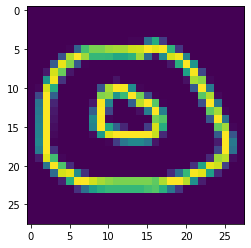

In [0]:
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

**Reshape and normalize each train and test image to 28x28 if not already**

In [0]:
image_size = 28
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape[1:])

(28, 28, 1)


**Define Model Architecture**

In [0]:
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))  # The number here should be equal to number of classes

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

**Train the model**

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=10)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/10
1152000/1152000 [==============================] - 24s 21us/sample - loss: 1.3460 - top_k_categorical_accuracy: 0.8713 - val_loss: 0.9998 - val_top_k_categorical_accuracy: 0.9183
Epoch 2/10
1152000/1152000 [==============================] - 23s 20us/sample - loss: 0.9162 - top_k_categorical_accuracy: 0.9273 - val_loss: 0.8854 - val_top_k_categorical_accuracy: 0.9292
Epoch 3/10
1152000/1152000 [==============================] - 23s 20us/sample - loss: 0.8294 - top_k_categorical_accuracy: 0.9352 - val_loss: 0.8247 - val_top_k_categorical_accuracy: 0.9361
Epoch 4/10
1152000/1152000 [==============================] - 24s 21us/sample - loss: 0.7846 - top_k_categorical_accuracy: 0.9395 - val_loss: 0.7927 - val_top_k_categorical_accuracy: 0.9381
Epoch 5/10
1152000/1152000 [==============================] - 23s 20us/sample - loss: 0.7553 - top_k_categorical_accuracy: 0.9420 - val_loss: 0.7777 - val_top_k_categorical_accuracy: 0.93

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 94.29%


**Use random test images to test the model**

['sword', 'knife', 'airplane', 'baseball_bat', 'pencil']


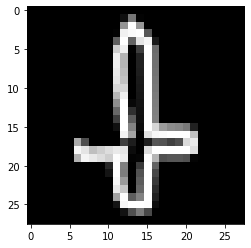

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze(),cmap='Greys_r') 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [0]:
model.save('keras.h5')

### **Prediction on Input image**

**Load the Model and Class Names for predictions**

In [0]:
model = tf.keras.models.load_model('100_classes_16000_per_class.h5')

class_names = ['saw', 'coffee_cup', 'power_outlet', 'microphone', 'triangle', 'cat', 'paper_clip',
               'drums', 'diving_board', 'sun', 'scissors', 'butterfly', 'ladder', 'beard', 'helmet',
               'bicycle', 'face', 'eye', 'syringe', 'bed', 'smiley_face', 'sword', 'door', 'spider',
               'bridge', 'spoon', 'fan', 'cell_phone', 'donut', 'rifle', 'baseball_bat', 'camera', 
               'baseball', 'screwdriver', 'table', 'anvil', 'frying_pan', 'tree', 'chair', 'tooth',
               'rainbow', 'bench', 'star', 'ceiling_fan', 'headphones', 'moon', 'key', 'eyeglasses',
               'lollipop', 'cookie', 'hat', 'shorts', 'grapes', 'pencil', 'hot_dog', 'bird', 'basketball',
               'hammer', 'radio', 't-shirt', 'pizza', 'shovel', 'flower', 'clock', 'wristwatch', 'tent',
               'ice_cream', 'airplane', 'mushroom', 'wheel', 'bread', 'mountain', 'axe', 'stop_sign', 
               'lightning', 'car', 'laptop', 'snake', 'dumbbell', 'sock', 'cup', 'moustache', 'book', 
               'traffic_light', 'umbrella', 'line', 'suitcase', 'circle', 'candle', 'pants', 'tennis_racquet',
               'alarm_clock', 'square', 'pillow', 'cloud', 'broom', 'knife', 'light_bulb', 'apple', 'envelope']

**Make predictions on any input image**

['bed', 'bench', 'table', 'bridge', 'rainbow']


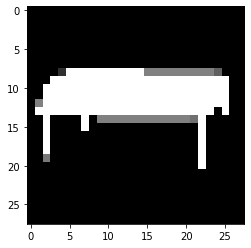

In [17]:
img = load_img('b.png', target_size=(28,28))
img = ImageOps.invert(img)
plt.imshow(img) 
img_tensor = img_to_array(img)

plt.imshow(img_tensor/255)

img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2GRAY) # Convert channel to 1 (grayscale)
img_tensor = np.expand_dims(img_tensor, axis=2) # Add last channel as 1  (28,28) to (28,28,1)
img_tensor = np.expand_dims(img_tensor, axis=0) # Add 1 more channel at start to specify number of input images (1,28,28,1)
img_tensor /= 255. 

#print(img_tensor.shape)

pred = model.predict(img_tensor)[0]
ind = (-pred).argsort()[:5]
objs = [class_names[x] for x in ind]
print(objs)


In [1]:
!pip install lime
import lime 
from lime import lime_image
from skimage.segmentation import mark_boundaries

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=74a2b627850adde3c19067ecbfbefe4c41bbb0b3eb994ad7e144a894f51db87d
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12073 sha256=61485ce1f4d7c9cfc21ca38e3ba57129d2e99e1e4284445e284b82cf96a8ab7a
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
img_path='./dataset/test/sunrise/'+sun_rise[7]  ### repalce path with the path for image u want to be expalined
img = image.load_img(img_path, target_size=(150, 150))
img = image.img_to_array(img)/255

plt.imshow(img)
plt.title('Image')
plt.show()

img = np.expand_dims(img, axis=0)